# Machine Learning Inspired Wind Energy Forecast
### Andrew LaCroix
##### TDI Fellow, Spring 2019<br><br><br>

## Why this project?
#### 1) My background
After completing my PhD, I taught a course on *Engineering Design and Communication*, leading several teams to create engineering solutions for challenges related to climate change. As my teams were finishing up their prototypes and I was applying to The Data Incubator, I decided to pursue a design project of my own aimed at providing a data-driven solution to a computational challenge in climate change and renewable energy.

#### 2) Richness of data
Another motivating factor that led me to pursue this project was the opportunity to interact with complex, multi-variate data from several sources. Some of the most important discoveries I made during graduate school were derived from the combination of two (or more) distinct datasets or tools to answer a more complex, and more relevant question. This capstone project combines machine learning with two large, spatially-varying, and multivariate datasets. Together, they provide a new resource to help guide the growth of renewable energy technology.

#### 3) Drive growth in renewable energy technology
What is keeping us from achieving 100% renewable energy? In a word, *variability*. The amount of energy produced by renewable energy sources such as solar and wind varies significantly hour-by-hour, day-by-day. Since energy grids require a near perfect balance between energy generation and energy demand, other sources of power are needed when the sun doesn't shine or the wind doesn't blow. Currently, the variability in renewable energy sources is balanced by fossil fuels, which isn't ideal. However, it could be balanced by other renewables, most promisingly pumped hydroelectric stations. These stations act as giant batteries and can store excess energy when production exceeds demand or deliver energy on-demand. This technology presents us with both a business problem and a business opportunity, both of which can be solved by an accurate long-term forecast:
 - __PROBLEM:__ These stations need to know hours to days in advance how much stored energy will be required. If the forecast is inacurate, then the pumped-hydro power station "battery" will run out, making for some very unhappy customers.
 - __OPPORTUNITY:__ If we know hours to days in advance how much excess energy will be produced (above demand), then energy grids can sell this surplus to other energy provides, generating revenue!

Overall, an accurate, long-term energy forecast will help us to reach 100% renewable energy power while simuntaneously maximizing energy grid stability and revenue for energy providers.<br><br>

## Approach
#### Current forecasting methods
Overview of first-principles models

Benefits:
 - Doesn't rely on other data sources
 
Limitations:
 - forecasts only accurate in limited time-window
 - computationally intensive

#### Long Short Term Memory (LSTM) for Multivariate Time-Series Forecasting
Overview of LSTM deep-learning model

Benefits:
 - Long-term forecasting!
 - Computationally manageable (retraining models is fast)
 - Leverages multivariate data well - if more predictors/datasets 
 
Limitations:
 - Relies on accuracy of weather predictions - want better predictions, get better data
 - Less interpretable than physical model - LSTM is a "black box" the inner-workings of which are difficult to understand


## Analysis Overview
1) Data wrangling energy and weather data

2) Exploratory data analysis to guide forecasting model

3) Forecasting model development

4) Forecasting model evaluation


### Part 1: Data wrangling

#### Wind Energy Generation
 - Final dataset comes from [IESO](http://www.ieso.ca/en/Power-Data/Data-Directory) (Independent Electricity System Operator) of Ontario, Canada
 - Hourly wind energy generation data can be found [here](http://reports.ieso.ca/public/GenOutputCapability/PUB_GenOutputCapability.xml) in `.xml` format
 - Wind farm locations were manually estimated based on this [system map](http://www.ieso.ca/localContent/ontarioenergymap/index.html), saved as `ieso_locations.csv`

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
from IPython.display import display
from pandas_profiling import ProfileReport
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

In [2]:
# Function that creates hour, date, datetime (date + hour) columns in energy dataframes
def fix_dt(df):
    # temporarily split date into three columns & append to existing df
    dates = df['Date'].str.split('-', expand=True)
    dates.columns = ['day','month','year']
    dates.loc[:,'day'] = dates['day'] # really need this!!!???
    df = pd.concat([df, dates], sort=False, axis=1)
    
    # zero-pad days and hours
    df.loc[:,'day'] = df['day'].astype('int').apply(lambda x: '{0:02d}'.format(x))
    df.loc[:,'hour'] = (df['Hour'].astype('int') - 1).apply(lambda x: '{0:02d}'.format(x))
    
    # create date and datetime columns
    df.loc[:,'date'] = \
        df['year'].astype('str') + '-' +\
        df['month'].astype('str') + '-' +\
        df['day'].astype('str')
    df.loc[:,'datetime'] = df['date'].astype('str') + '-' + df['hour'].astype('str')
    
    # convert to datetimeobjects
    df.loc[:,'date'] = pd.to_datetime(df['date'], format='%y-%b-%d')
    df.loc[:,'datetime'] = pd.to_datetime(df['datetime'], format='%y-%b-%d-%H')
    
    # drop miscellaneous columns we don't need
    df.drop(columns = ['Date','Hour','year', 'month', 'day'], inplace=True)
    
    # convert hour back to integer
    df.loc[:,'hour'] = df['hour'].astype('int')
    
    # get rid of Feb 29th datas since they don't occur every year
    df = df.loc[df['date'] != dt.datetime(2016, 2, 29),:]
    return df

In [3]:
# Funtion that extracts names of wind stations for which
# we have BOTH location and power output information
def get_common_stations(wind_farms_df, output_df):
    # Wind farm locations
    wind_farms_with_loc_data = wind_farms_df.loc[
        (wind_farms_df['in_dataset']==1) &
        (wind_farms_df['station_type']=='Wind'), 'station_name'].values

    # Wind farm power output
    nentries = output_df.TOTAL.count()
    wind_farms_with_output_data = list(output_df.loc[:,output_df.count() > (0.9*nentries)].columns)

    # Combine
    wind_farm_names = [name for name in wind_farms_with_loc_data if name in wind_farms_with_output_data]
    print(len(wind_farm_names),'wind farms in Ontario to analyze')
    return wind_farm_names

In [24]:
####### Import, clean, combine, & save wind ########
######### energy data for 2015 thru 2018 ###########

### input parameters to power analysis
years = [2015, 2016, 2017, 2018]
wind_farms_df = pd.read_csv('wind_power_csv/ieso_locations.csv') # wind farm locations
output_df = pd.DataFrame(columns = ['hour', 'date', 'datetime', 'station_name', 'power_output', 'pred_power_output', 'max_power_output', 'pmax_power_output', 'pred_pmax_power_output'])
for year in years:
    # Import wind farm location, energy generation, and predicted energy generation data
    true_output_df = fix_dt(pd.read_csv('wind_power_csv/GOC-' + str(year) + '-output.csv')) # energy gen
    pred_output_df = fix_dt(pd.read_csv('wind_power_csv/GOC-' + str(year) + '-capabilities.csv')) # predicted energy gen

    # Filter station data down to those with usable data (both location info AND output data)
    if year == 2015:
        wind_farm_names = get_common_stations(wind_farms_df, true_output_df)
    wind_farms_df = wind_farms_df[wind_farms_df['station_name'].isin(wind_farm_names)]
    true_output_df = true_output_df.interpolate().ffill().bfill() # fill in missing data (< 0.001% of data)
    true_output_df = true_output_df.loc[:,['hour','date','datetime'] + wind_farm_names]
    pred_output_df = pred_output_df.interpolate().ffill().bfill() # fill in missing data
    pred_output_df = pred_output_df.loc[:,['hour','date','datetime'] + wind_farm_names]

    # Reshape output data for further analysis
    # originally: one column per station
    # reshaped: "station_name" and "power_output" columns
    melt_true_output_df = pd.melt(true_output_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="power_output")                                
    melt_pred_output_df = pd.melt(pred_output_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="pred_power_output")                                

    # Combine true and predicted energy generation data
    # Also add normalized (percent max power gen for both true and predicted output)
    cmb_melt_true_output_df = melt_true_output_df
    cmb_melt_true_output_df['pred_power_output'] = melt_pred_output_df['pred_power_output']
    cmb_melt_true_output_df['max_power_output'] = cmb_melt_true_output_df['power_output'].groupby(cmb_melt_true_output_df['station_name']).transform('max')
    cmb_melt_true_output_df['pmax_power_output'] = cmb_melt_true_output_df['power_output'] / cmb_melt_true_output_df['max_power_output']
    cmb_melt_true_output_df['pred_pmax_power_output'] = cmb_melt_true_output_df['pred_power_output'] / cmb_melt_true_output_df['max_power_output']
        
    # concatenate with other years of data
    output_df = pd.concat((output_df, cmb_melt_true_output_df), sort=False, axis=0)
    
# join data with metadata for full dataset
output_df.set_index('station_name', inplace=True)
wind_farms_df.set_index('station_name', inplace=True)

output_df = output_df.join(wind_farms_df.loc[:,['latitude','longitude']])

output_df.reset_index(inplace=True)
wind_farms_df.reset_index(inplace=True)

25 wind farms in Ontario to analyze


In [5]:
# make sure calcs worked as expected
ProfileReport(output_df)

Number of variables,11
Number of observations,876000
Total Missing (%),0.0%
Total size in memory,73.5 MiB
Average record size in memory,88.0 B
Numeric,8
Categorical,1
Boolean,0
Date,2
Text (Unique),0
Rejected,0


In [25]:
# plot some energy vs time
# visualize hourly wind power generation at station n
def plot_power_data(df, station, yvar, year=2015, month=1, start_day=1, end_day=15):
    
    # convert dates to datetime format
    start_date = dt.datetime(year, month, start_day)
    end_date = dt.datetime(year, month, end_day)
    
    # data from single station
    tmpdf = df.loc[
        (df['datetime']>start_date) & 
        (df['datetime']<end_date) & 
        (df['station_name']==station)]
    
    # plot parameters for that station
    if yvar == 'MW':
        column1 = 'power_output'
        column2 = 'pred_power_output'
        ymax = tmpdf['power_output'].max() * 1.175
    elif yvar == '%max':
        column1 = 'pmax_power_output'
        column2 = 'pred_pmax_power_output'
        ymax = 1.175
        
    # Construct plot
    f,ax = plt.subplots(figsize=(12,4))
    sns.lineplot(x='datetime', y=column1, data=tmpdf, color="#9b59b6", label=column1)
    sns.lineplot(x='datetime', y=column2, data=tmpdf, color="#3498db", label=column2)
    ax.set_xlim([start_date, end_date])
    plt.xticks(rotation=90)
    ax.set_ylabel('Power Generation at\n' + station + ' wind farm (' + yvar + ')')
    ax.set_xlabel('Date')
    ax.set_ylim([0, ymax])
    plt.legend(loc = 'upper center', ncol = 2)
    plt.show();

In [26]:
interact(plot_power_data,\
         df = fixed(output_df),\
         station = wind_farm_names,\
         yvar = ['MW','%max'],\
         year = years,\
         month = (1,12,1),\
         start_day = (1,31,1),\
         end_day = (1,31,1));

interactive(children=(Dropdown(description='station', options=('ADELAIDE', 'AMARANTH', 'BLAKE', 'BORNISH', 'CO…

#### Weather Data
 - Hourly temperature, wind speed, wind direction data from individual weather stations is collected by National Oceanographic and Atmospheric Association (NOAA) and can be accessed via [NOAA's FTP server](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/2018/)
 - Station metadata (`latitude`, `longitude`, `station_id`, etc.) is found in the `isd_inventory.txt` file [here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa)

In [27]:
# Function to clean up metadata
# 1) clean up datetime
# 2) filter on a number of aspects in order to closely match power generation data with this weather data
#      - date range for which data is available
#      - country (canadian stations only)
#      - province (latitude, longitude)
# 3) remove nan stations with ID = 999999
# Note: we will pair individual wind farms and weather stations later

def clean_metadata(df, years):
    # Convert dates to datetime
    df['begin'] = pd.to_datetime(df['begin'], format='%Y%m%d') # convert to date-time format
    df['end'] = pd.to_datetime(df['end'], format='%Y%m%d') #convert to date-time format

    # filter on country (Canadian stations)
    df = df.loc[df['country_id']=='CA']

    # filter on date (only those with recent data included)
    date_after = dt.datetime(years[0], 1, 1)
    date_before = dt.datetime(years[-1]+1, 1, 1)
    df = df.loc[(df['begin']<date_after) & (df['end']>date_before)]

    # Filter on location (hone in on province of Ontario)
    lat_lims = [41.328637, 57.220554]
    lon_lims = [-96.030845, -73.223228]
    df = df.loc[(df['latitude']>lat_lims[0]) & (df['latitude']<lat_lims[1])]
    df = df.loc[(df['longitude']>lon_lims[0]) & (df['longitude']<lon_lims[1])]

    # remove station id 9999 and make station_id int type
    df = df.rename(columns={'af_station_id':'station_id'})
    df = df.loc[df['station_id']!='999999',:]
    
    # drop miscelaneous columns that we either never needed, or no longer need
    dropcols = ['ncdc_station_id','name','country_id','airport_id','begin','end']
    df = df.drop(columns = dropcols)
    
    print('Number of stations in Canada with at least four recent years of data:', len(df))
    return df

In [28]:
# Load & clean weather station metadata (station IDs, latitude, longitude, etc.)
wthr_stns_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt'
column_names = ['af_station_id', 'ncdc_station_id', 'name', 'country_id', 'airport_id', 'latitude', 'longitude', 'elevation', 'begin', 'end']
n_misc_rows = 22
wthr_stns_df = pd.read_fwf(wthr_stns_url, skiprows=n_misc_rows, names=column_names)
wthr_stns_df = clean_metadata(wthr_stns_df, years)

Number of stations in Canada with at least four recent years of data: 153


153 unique station_id's in dataset


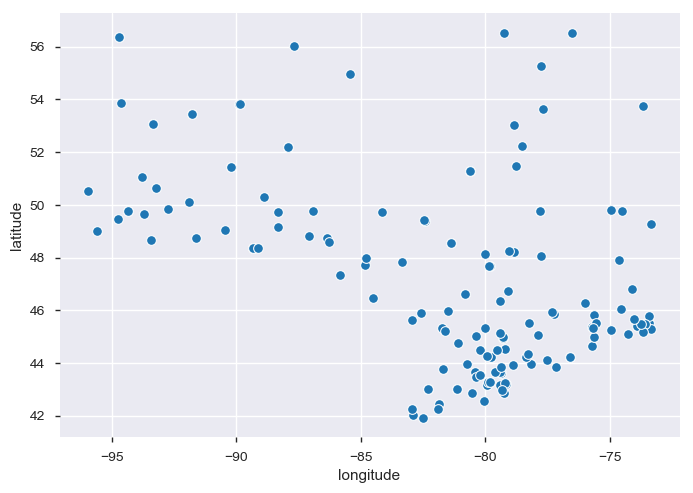

In [29]:
# take a look at where these stations are located
print(len(wthr_stns_df['station_id'].value_counts()),'unique station_id\'s in dataset')
sns.scatterplot(x='longitude', y='latitude', data=wthr_stns_df);

In [30]:
# Determines naming scheme for each filename
def get_filenames(url, df):
    fndf = pd.read_fwf(url, names = ['a','b','c','d','e','f','g','h','filename'])
    split_fndf = fndf['filename'].str.split('-', expand=True)
    split_fndf.columns = ['a','b','c']
    subset = split_fndf[split_fndf['a'].isin(df['station_id'])]
    subset.loc[:,'filename'] = url + '/' + subset['a'] + '-' + subset['b'] + '-' + subset['c'] # reassemble filename
    subset = subset.drop(columns = ['a','b','c'])
    subset = subset.reset_index()
    return subset

In [31]:
# Converts units within each dataset
def convert_units(df):
    null_vals = [9999, 999, -0.9999, -9999]
    for val in null_vals:
        df.replace(val, np.nan, inplace=True)
    df.loc[:,'temp'] = df['temp'] * 0.1 * (9/5) + 32# in Farenheit
    df.loc[df['temp']>100, 'temp'] = 100
    df.loc[:,'dew_point'] = df['dew_point'] * 0.1 * (9/5) + 32 # in Farenheit
    df.loc[:,'pressure'] = df['pressure'] * 0.01 # in kPa
    df.loc[:,'pressure'] = df['pressure'].interpolate() # fill in some nan values present in the original data
    df.loc[:,'wind_speed'] = df['wind_speed'] * 0.2237 # in mph
    df.loc[:,'precip_1hr'] = df['precip_1hr'] * 0.003937007866 # in inches
    df.loc[:,'precip_6hr'] = df['precip_6hr'] * 0.003937007866 # in inches
    return df

In [32]:
# method to concatenate year, month, day, hour into datetime object
def concat_dt(df, year):
    # create datetime that we'll reference when we re-index the dataset
    df.loc[:,'datetime'] = df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + df['day'].astype('str') + '-' + df['hour'].astype('str')
    df.loc[:,'datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d-%H')
    df.loc[:,'datetime'] = df['datetime'].dt.strftime('%Y-%m-%d-%H')
    
    # Fill missing dates with nan then mean of the two data points on either side of it
    truedaterange = pd.date_range('01-01-'+str(year)+' 00:00:00', '12-31-'+str(year)+' 23:59:59', freq='H')
    df.index = pd.DatetimeIndex(df['datetime'])
    df = df.reindex(truedaterange, fill_value=np.nan)
    
    # Recover appropriate time parameters
    df.loc[:,'hour'] = df.index.hour
    df.loc[:,'day'] = df.index.day
    df.loc[:,'month'] = df.index.month
    df.loc[:,'year'] = df.index.year
    df.loc[:,'date'] = df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + df['day'].astype('str')
    df.loc[:,'date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.reset_index(inplace=True)
    df.drop(columns='datetime', inplace=True)
    df.rename(columns={'index':'datetime'}, inplace=True)
    
    # get rid of Feb 29th datas since they don't occur every year
    df = df.loc[df['date'] != dt.datetime(2016, 2, 29),:]
    return df

In [33]:
# Flags dataset for removal if it has a lot of missing data
def exclude_missing_data(df):
    flag_for_removal = False
    n_null_temp = sum(df['temp'].isna())
    n_null_wind_speed = sum(df['wind_speed'].isna())
    n_null_wind_dir = sum(df['wind_dir'].isna())
    n_null_pressure = sum(df['pressure'].isna())
    n_null_list = [n_null_temp, n_null_wind_speed, n_null_wind_dir, n_null_pressure]
    if any([x>876 for x in n_null_list]):
        flag_for_removal = True
    df = df.interpolate().ffill().bfill() # interpolate a few missing values
    return df, n_null_list, flag_for_removal

In [34]:
def load_weather_data(filenames, column_names, year, bad_stations):
    result = pd.DataFrame(data = [], columns = column_names + ['date','station_id','datetime'])
    n_stations_processed = 0
    n_stations_total = 0
    for file in filenames['filename']:
        while True:
            try:
                tmp = pd.read_fwf(file, names = column_names)
            except:
                continue
            break
        tmp = pd.read_fwf(file, names = column_names)
        tmp = convert_units(tmp)
        tmp = concat_dt(tmp, year)
        tmp, nl, ffr = exclude_missing_data(tmp)
        tmp.loc[:,'station_id'] = file[-20:-14]
        
#       only append if there is pressure and wind direction data available for the vast majority of the dataset
        if tmp.loc[:,'station_id'].values[0] in bad_stations:
            print('skipped station ' + str(file[-20:-14]) + ' - previously identified...' + str(n_stations_processed) + ' stations processed so far')
        elif ffr==True: # previously flagged for removal in `exclude_missing_data` function
            print('skipped station ' + str(file[-20:-14]) + ' - flagged for removal...' + str(n_stations_processed) + ' stations processed so far')
        elif tmp['pressure'].isnull().values[0] == True:
            print('skipped station ' + str(file[-20:-14]) + ' - no pressure data...' + str(n_stations_processed) + ' stations processed so far')
        elif tmp['wind_dir'].mean() < 20:
            print('skipped station ' + str(file[-20:-14]) + ' - no wind direction data...' + str(n_stations_processed) + ' stations processed so far')
        else:
            result = pd.concat([result,tmp], sort=False, axis=0)
            n_stations_processed+=1
        n_stations_total+=1
    print(str(n_stations_processed) + ' out of ' + str(n_stations_total) + ' stations passed data quality checkpoints')
    return result

In [35]:
# Pipeline of weather data injestion
try:
    # attempt to reload the previously saved unfiltered weather data
    weather_df = pd.read_csv('unfiltered_weather_df.csv')
    print('Yay! You\'ve already done the hard work of loading and cleaning data from the FTP servier. Off to the races!')
    # Just need to fix date and datetime columns and remove the index (which was saved as a column named "Unnamed: 0"
    weather_df.drop(columns='Unnamed: 0', inplace=True)
    weather_df.loc[:,'station_id'] = weather_df['station_id'].astype('int')
    weather_df.loc[:,'date'] = pd.to_datetime(weather_df['date'], format='%Y-%m-%d')
    weather_df.loc[:,'datetime'] = pd.to_datetime(weather_df['datetime'], format='%Y-%m-%d %H')
except:
    print('We\'re in for the long haul...data needs to be loaded from the FTP server')
    url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/'
    column_names = ['year','month','day','hour','temp','dew_point','pressure','wind_dir','wind_speed','sky_conditions','precip_1hr','precip_6hr']
    bad_stations = ['710514','710720','710980','711450','711720','711830','711960','712080','712625',\
                    '712980','712990','713010','713030','713041','713720','713910','713980','714300',\
                    '714310','714340','714360','714390','714620','714630','714640','714650','715080',\
                    '715230','715320','715700','715870','716200','716220','716279','716300','716390',\
                    '716400','716420','716720','716780','716971','717320','717370','717380','717490',\
                    '717510','717550','718210','718220','718230','718240','718320','718330','718350',\
                    '718420','718436','718443','718450','718540','718964','719050','719053','719104',\
                    '719120','719470','719560','712970','714370','715240','717365','717366','718460',\
                    '710990','711930','712130','712950','713760','714330','715730','717493']
    weather_df = pd.DataFrame(columns = column_names + ['date','station_id','datetime'])
    for year in years:
        ftp_url = url + str(year) + '/'
        filenames = get_filenames(ftp_url, wthr_stns_df)
        station_weather_df = load_weather_data(filenames, column_names, year, bad_stations)
        print(station_weather_df.shape)

        # combine with previous years
        weather_df = pd.concat((weather_df, station_weather_df), sort=False, axis=0)
    weather_df.drop(columns=['sky_conditions', 'precip_1hr', 'precip_6hr'], inplace=True) # not going to be used in this analysis
    weather_df.loc[:,'wind_dir'] = weather_df['wind_dir'].astype('int') # these values are always in steps of 10 degrees
    weather_df.to_csv('unfiltered_weather_df.csv')

# Apply list of unique weather stations that passed QC to weather station metadata (wthr_stns_df)
good_weather_stations = np.unique(weather_df['station_id'].values)
wthr_stns_df.loc[:,'station_id'] = wthr_stns_df['station_id'].astype('int')
print('We began with ' + str(len(wthr_stns_df)) + ' weather stations')
good_wthr_stns_df = wthr_stns_df.loc[wthr_stns_df['station_id'].isin(good_weather_stations), :]
print('Now, only ' + str(len(good_wthr_stns_df)) + ' passed QC')
display(weather_df.head(5))

# join weather data with weather station metadata for full weather dataset
weather_df.set_index('station_id', inplace=True)
good_wthr_stns_df.set_index('station_id', inplace=True)

weather_df = weather_df.join(good_wthr_stns_df.loc[:,['latitude','longitude']])

weather_df.reset_index(inplace=True)
good_wthr_stns_df.reset_index(inplace=True)

Yay! You've already done the hard work of loading and cleaning data from the FTP servier. Off to the races!
We began with 153 weather stations
Now, only 73 passed QC


,year,month,day,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,station_id,datetime
0,2015,1,1,0,0.68,-3.64,99.85,330,25.2781,2015-01-01,710377,2015-01-01 00:00:00
1,2015,1,1,1,-6.88,-13.36,100.02,330,23.0411,2015-01-01,710377,2015-01-01 01:00:00
2,2015,1,1,2,-8.50,-15.88,100.11,330,20.8041,2015-01-01,710377,2015-01-01 02:00:00
3,2015,1,1,3,-8.14,-14.26,100.14,320,17.2249,2015-01-01,710377,2015-01-01 03:00:00
4,2015,1,1,4,-9.04,-13.90,100.22,320,19.4619,2015-01-01,710377,2015-01-01 04:00:00


In [17]:
ProfileReport(weather_df)

Number of variables,14
Number of observations,2557920
Total Missing (%),0.0%
Total size in memory,273.2 MiB
Average record size in memory,112.0 B
Numeric,11
Categorical,0
Boolean,0
Date,2
Text (Unique),0
Rejected,1


In [36]:
# plot some energy vs time
# visualize hourly wind power generation at station n
def plot_weather_data(df, station_id, column, year=2015, month=1, start_day=1, end_day=15):
    
    # convert dates to datetime format
    start_date = dt.datetime(year, month, start_day)
    end_date = dt.datetime(year, month, end_day)
    
    # data from single station
    tmpdf = df.loc[
        (df['datetime']>start_date) & 
        (df['datetime']<end_date) & 
        (df['station_id']==station_id)]
    
    # Construct plot
    f,ax = plt.subplots(figsize=(12,4))
    sns.lineplot(x='datetime', y=column, data=tmpdf, color="#95a5a6")
    ax.set_xlim([start_date, end_date])
    plt.xticks(rotation=90)
    ax.set_ylabel(column + ' at weather station #' + str(station_id))
    ax.set_xlabel('Date')
    plt.show();

In [37]:
interact(plot_weather_data,\
         df = fixed(weather_df),\
         station_id = good_weather_stations,\
         column = weather_df.columns[5:10],\
         year = years,\
         month = (1,12,1),\
         start_day = (1,31,1),\
         end_day = (1,31,1));

interactive(children=(Dropdown(description='station_id', options=(710377, 710630, 711510, 711610, 711710, 7126…

#### Combine weather + power data
 - Use wind farm and weather station metadata to determine which pairs of facilities are closest
 - Calculations follow the logic in [this post](https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates) and are just based on `latitude` and `longitude`, assuming (in this limited region) that the landscape can be approximated as a flat plane (I get to be a flat-earther for a bit!)

In [38]:
# calculate nearest neighbors and separation distance for weather station : wind farm combos
from scipy import spatial

A = wind_farms_df.loc[:,['latitude','longitude']].values
B = good_wthr_stns_df.loc[:,['latitude','longitude']].values
inds = [spatial.KDTree(B).query(A[pt])[1] for pt in range(len(A))]
dists = [spatial.KDTree(B).query(A[pt])[0] for pt in range(len(A))]
miledists = [d*69 for d in dists] # convert to miles

In [55]:
# create dict of key:value pairs for wind farm : [weather_station, distance-to-weather-station] pairings
def pair_up(df1, df2, distances):
    pairs = {}
    for f, farm in enumerate(df1.loc[:,'station_name']):
        pairs[farm] = [df2.loc[inds[f],'station_id'], distances[f]]

    # make pairs into a data frame for joining
    tmp0 = pd.DataFrame(pd.DataFrame(pairs).iloc[0,:].astype(int))
    tmp1 = pd.DataFrame(pd.DataFrame(pairs).iloc[1,:])
    pairs = pd.concat((tmp0,tmp1),axis=1)
    pairs.columns=['station_id','distance']

    # make sure indices of `pairs` and `weather_df` match up
    pairs.reset_index(inplace=True)
    pairs.rename(columns={'index':'station_name'}, inplace=True)
    return pairs

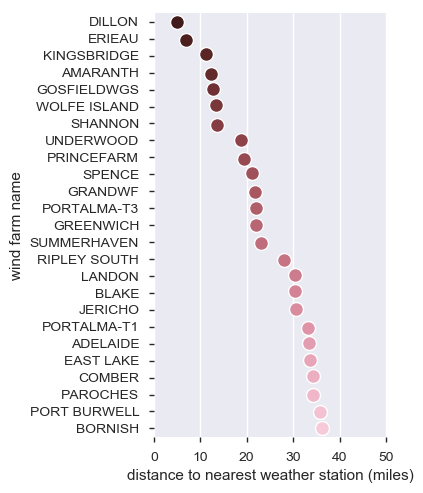

In [56]:
# Visualize distances between pairs of weather stations and wind farms
pairs = pair_up(wind_farms_df, good_wthr_stns_df, miledists)
f, ax = plt.subplots(figsize=(3,5.5))
sns.stripplot(x="distance", y="station_name", data=pairs.sort_values("distance", ascending=True),\
        size=10, orient="h", palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")
ax.set_xlabel('distance to nearest weather station (miles)')
ax.set_ylabel('wind farm name')
ax.set_xlim([0,50])
plt.show();

In [89]:
### JOIN pairs with weather_df ###
# make pairs df with station_id index
pairs1 = pair_up(wind_farms_df, good_wthr_stns_df, miledists)

pairs1.set_index('station_id', inplace=True)
# display(pairs1.head(2))

joinable_weather_df = weather_df.set_index('station_id')
joinable_weather_df = joinable_weather_df.sort_values(['station_id', 'datetime'])
# display(joinable_weather_df.head(2))

# Join and do some final cleaning up of column names
final_weather_df = joinable_weather_df.join(pairs1).reset_index()
final_weather_df.dropna(inplace=True) # remove those that didn't match up
final_weather_df.reset_index(inplace=True) # recover station_id column
final_weather_df.drop(columns='index', inplace=True)
final_weather_df = final_weather_df.loc[final_weather_df['distance']<=50, :]
final_weather_df = final_weather_df.sort_values(['station_name', 'datetime']).reset_index()
final_weather_df = final_weather_df.drop(columns = 'index')
# display(final_weather_df.head(2))

In [90]:
### JOIN pairs with output_df ###
# make pairs df with station_name index
pairs2 = pair_up(wind_farms_df, good_wthr_stns_df, miledists)
pairs2.set_index('station_name', inplace=True)
# display(pairs2.head(2))
joinable_output_df = output_df.set_index('station_name')
joinable_output_df = joinable_output_df.sort_values(['station_name', 'datetime'])
# display(joinable_output_df.head(2))

# Join and do some final cleaning up of column names and data to exclude
final_output_df = joinable_output_df.join(pairs2).reset_index()
final_output_df = final_output_df.loc[final_output_df['distance']<=50,:]
final_output_df = final_output_df.sort_values(['station_name', 'datetime']).reset_index()
final_output_df = final_output_df.drop(columns = 'index')
# display(final_output_df.head(2))

In [91]:
# Triple check that we have indexed everything correctly
print(len(final_output_df))
print(len(final_weather_df))
print(sum(final_output_df.datetime==final_weather_df.datetime))

876000
876000
876000


In [373]:
df = pd.DataFrame({'Col1': [10, 20, 15, 30, 45],\
                    'Col2': [13, 23, 18, 33, 48],\
                    'Col3': [17, 27, 22, 37, 52]})
display(df)
display(df.shift(periods=-3))

,Col1,Col2,Col3
0,10,13,17
1,20,23,27
2,15,18,22
3,30,33,37
4,45,48,52


,Col1,Col2,Col3
0,30.0,33.0,37.0
1,45.0,48.0,52.0
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [431]:
def shift_datetime(df, stations, shift_cols, noshift_cols, shift=-5):
    result = pd.DataFrame(columns = noshift_cols + shift_cols)
    for station in stations:
        # shift columns corresponding to weather data backwards in time (from UTC to EST)
        shiftdf = df.loc[df['station_name']==station, shift_cols]
        shiftdf = shiftdf.shift(periods=shift)
        shiftdf = shiftdf.dropna()
        shiftdf = shiftdf.reset_index()
        shiftdf = shiftdf.drop(columns='index')
        
        # don't shift, but truncate the other columns of the dataframe (keeping datetime)
        noshiftdf = df.loc[df['station_name']==station, noshift_cols]
        noshiftdf = noshiftdf.iloc[:shift]
        noshiftdf = noshiftdf.reset_index()
        noshiftdf = noshiftdf.drop(columns='index')
                
        # combine shift + noshift
        shifted_df = pd.concat((noshiftdf, shiftdf), sort=False, axis=1)
        
        # append to end of growing result
        result = pd.concat((result, shifted_df), sort=False, axis=0)
    return result

In [434]:
# join power and weather together into one final dataset for analysis and time-series modeling
wthrfeats = ['station_name', 'datetime', 'hour', 'day', 'month', 'year', 'wind_speed', 'wind_dir', 'temp', 'dew_point', 'pressure', 'latitude', 'longitude']
pwrfeats = ['station_name', 'datetime', 'power_output', 'pred_power_output', 'pmax_power_output', 'pred_pmax_power_output']
df1 = final_output_df.loc[:, pwrfeats].rename(columns={'datetime':'datetime_pwr', 'station_name':'station_name_pwr'})
df2 = final_weather_df.loc[:, wthrfeats].rename(columns={'datetime':'datetime_wthr', 'station_name':'station_name_wthr'})
stations = list(final_output_df.groupby('station_name').count().index)
if sum(df1.datetime_pwr==df2.datetime_wthr) != 876000:
    print('You may have a problem with the joining of weather and power data')
df = df1.join(df2)
df = df.drop(columns=['datetime_wthr','station_name_wthr']).rename(columns={'datetime_pwr':'datetime', 'station_name_pwr':'station_name'})
display(df.dtypes)
print(len(df))
# figured out that we have EST for power data, but UTC for weather data
# As a result, we need to shift the data around to make them align in time
noshift_cols = ['station_name','datetime','power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','hour','day','month','year']
shift_cols = ['wind_speed','wind_dir','temp','dew_point','pressure','latitude','longitude']
df = shift_datetime(df, stations, shift_cols, noshift_cols, shift=-5)

#recover datetime index
df.set_index('datetime', inplace=True)
display(df.head(7))
display(df.dtypes)
print(len(df))

station_name                      object
datetime                  datetime64[ns]
power_output                     float64
pred_power_output                float64
pmax_power_output                float64
pred_pmax_power_output           float64
hour                               int64
day                                int64
month                              int64
year                               int64
wind_speed                       float64
wind_dir                           int64
temp                             float64
dew_point                        float64
pressure                         float64
latitude                         float64
longitude                        float64
dtype: object

876000


,station_name,power_output,pred_power_output,pmax_power_output,pred_pmax_power_output,hour,day,month,year,wind_speed,wind_dir,temp,dew_point,pressure,latitude,longitude
datetime,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,ADELAIDE,58.0,57.0,0.983051,0.966102,0,1,1,2015,19.6856,240.0,17.60,3.20,101.78,43.036,-81.154
2015-01-01 01:00:00,ADELAIDE,57.0,57.0,0.966102,0.966102,1,1,1,2015,21.9226,240.0,16.88,4.82,101.71,43.036,-81.154
2015-01-01 02:00:00,ADELAIDE,56.0,55.0,0.949153,0.932203,2,1,1,2015,18.3434,240.0,17.60,6.80,101.69,43.036,-81.154
2015-01-01 03:00:00,ADELAIDE,58.0,57.0,0.983051,0.966102,3,1,1,2015,16.1064,230.0,17.60,8.60,101.68,43.036,-81.154
2015-01-01 04:00:00,ADELAIDE,58.0,58.0,0.983051,0.983051,4,1,1,2015,18.3434,210.0,17.60,8.60,101.62,43.036,-81.154
2015-01-01 05:00:00,ADELAIDE,57.0,57.0,0.966102,0.966102,5,1,1,2015,17.2249,230.0,17.60,8.60,101.57,43.036,-81.154
2015-01-01 06:00:00,ADELAIDE,57.0,57.0,0.966102,0.966102,6,1,1,2015,18.3434,230.0,17.60,8.60,101.56,43.036,-81.154


station_name               object
power_output              float64
pred_power_output         float64
pmax_power_output         float64
pred_pmax_power_output    float64
hour                       object
day                        object
month                      object
year                       object
wind_speed                float64
wind_dir                  float64
temp                      float64
dew_point                 float64
pressure                  float64
latitude                  float64
longitude                 float64
dtype: object

875875


### Part 2: Exploratory Data Analysis

Search for seasonality in energy generation
 - yearly (with temperature changes)
 - daily (with sun rise and set)
 - Look at moving average
      - day-to-day
      - year-to-year<br><br>

In [435]:
# yearly average and moving average
def yearly_avg(df, yvar='power_output', station='KINGSBRIDGE'):
    df = df.loc[df['station_name']==station]
    
    # visualize yearly average (day-by-day)
    avg_df = pd.DataFrame(df[yvar].groupby([(df.index.month),(df.index.day)]).mean())
    newindex = pd.DataFrame(avg_df.index.values)
    newindex['datetime'] = ['2019-' + '%02d' % x + '-' + '%02d' % y for x, y in newindex.loc[:,0]]
    avg_df.set_index(newindex['datetime'], inplace=True)
    avg_df.reset_index(inplace=True)

    # calculate moving average as well (average over 14 days)
    mvavg_df = pd.DataFrame(avg_df[yvar].rolling(14).mean())
    mvavg_df.set_index(newindex['datetime'], inplace=True)
    mvavg_df.reset_index(inplace=True)

    # clean up stupid leap year days and datetime columns
    avg_df = avg_df.loc[avg_df['datetime']!='2019-02-29',:]
    avg_df['datetime'] = pd.to_datetime(avg_df['datetime'], format = '%Y-%m-%d')
    mvavg_df = mvavg_df.loc[mvavg_df['datetime']!='2019-02-29',:]
    mvavg_df['datetime'] = pd.to_datetime(mvavg_df['datetime'], format = '%Y-%m-%d')

    # plot avg and moving average of the average
    fig,ax = plt.subplots(figsize=(8,4))
    sns.lineplot(x="datetime", y=yvar, data=avg_df, label='4-year avg', color='#3498db');
    sns.lineplot(x="datetime", y=yvar, data=mvavg_df, label= '2-week moving avg', color='#e74c3c', ax=ax);
    ax.set_title('Data for wind farm: ' + station)
    ax.set_xlabel('Date')
    
    # Clean up axes
    xmin = 737060
    xmax = 737425
    ax.set_xticks(np.linspace(xmin, xmax, 13))
    ax.set_xticklabels(['Jan-01','Feb-01','Mar-01','Apr-01','May-01','Jun-01','Jul-01','Aug-01','Sep-01','Oct-01','Nov-01','Dec-01','Dec-31'])
    plt.xticks(rotation=45)
    ax.set_xlim([xmin,xmax])
    ax.legend(loc = 'upper center', ncol = 2);

In [436]:
yvars = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','wind_speed','wind_dir','temp','dew_point','pressure']
interact(yearly_avg, df = fixed(df), yvar = yvars, station = stations);

interactive(children=(Dropdown(description='yvar', options=('power_output', 'pred_power_output', 'pmax_power_o…

In [437]:
def daily_avg(df, yvar='power_output', station='KINGSBRIDGE'):
    months = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    month_names = list(months.keys())
    clrs = sns.color_palette("hls", 12)
    clrs = clrs[-6:] + clrs[:6]
    fig,ax = plt.subplots(figsize=(6,4))
    
    df = df.loc[df['station_name']==station,:]

    # visualize daily average (hour-by-hour)
    avg_df = pd.DataFrame(df[yvar].groupby([(df.index.month), (df.index.hour)]).mean())
    avg_df.reset_index(level = 0, inplace=True)
    avg_df.columns = ['month', yvar]
    avg_df.reset_index(level=0, inplace=True)
    avg_df.columns = ['hour','month', yvar]

    # clean up datetime columns
    avg_df['datetime'] = ['2019-01-01 ' + '%02d' % x + ':00:00' for x in avg_df['hour'].values]
    avg_df['datetime'] = pd.to_datetime(avg_df['datetime'], format = '%Y-%m-%d %H')

    # plot avg metrics
    xmin = 737060
    xmax = 737060.95
    sns.lineplot(x="datetime", y=yvar, hue='month', data=avg_df, palette=clrs, ax=ax);
    ax.set_title('Data for wind farm: ' + station)
    ax.set_xlabel('Hour of the day')
    plt.xticks(rotation=45)
    ax.set_xlim([xmin, xmax])
    ax.set_xticks(np.linspace(xmin, xmax, 7))
    ax.set_xticklabels(['12:00 AM','4:00 AM','8:00 AM','12:00 PM','4:00 PM','8:00 PM','11:59 PM'])
    ax.legend(labels = month_names, bbox_to_anchor=(1.02, 0.9), title='Month');

In [438]:
yvars = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','wind_speed','wind_dir','temp','dew_point','pressure']
interact(daily_avg, df = fixed(df), yvar = yvars, station = stations);

interactive(children=(Dropdown(description='yvar', options=('power_output', 'pred_power_output', 'pmax_power_o…

In [440]:
# Find most promissing dataset by wind_speed-wind_power correlation
for station in stations:
    X = df.loc[df['station_name']==station, 'wind_speed']
#     X[X>60] = 60
    y = df.loc[df['station_name']==station, 'pmax_power_output']
#     y[y>1] = 1
    cc = np.corrcoef(X,y)
    cc = str(round(cc[0,1], 3))
    print(station + ' '*(20-len(station)) + 'R\u00B2 = ' + cc)
    
    # look at some subsets of the data
    train_interval = 7*24*2 # 2 week training dataset
    for i in range(100):    
        cut1 = i * train_interval # start idx of training dataset
        cut2 = (i + 1) * train_interval # end index of training dataset (and start index of test dataset)
        X_sub = X[cut1:cut2]
        y_sub = y[cut1:cut2]
        cc_sub = np.corrcoef(X_sub,y_sub)
        cc_sub = str(round(cc_sub[0,1], 3))
        print(' '*(20) + 'R\u00B2 = ' + cc_sub + '\t  ' + str(len(np.unique(X_sub))) + '\t  ' + str(len(np.unique(y_sub))))

ADELAIDE            R² = 0.466
                    R² = 0.761	  24	  60
                    R² = 0.719	  18	  59
                    R² = 0.573	  23	  60
                    R² = 0.656	  24	  57
                    R² = 0.483	  21	  58
                    R² = 0.712	  21	  58
                    R² = 0.508	  52	  59
                    R² = -0.12	  336	  57
                    R² = 0.43	  158	  57
                    R² = 0.645	  19	  57
                    R² = 0.642	  24	  58
                    R² = 0.579	  22	  56
                    R² = 0.748	  19	  54
                    R² = 0.512	  17	  48
                    R² = 0.595	  15	  48
                    R² = 0.48	  19	  46
                    R² = 0.51	  17	  50
                    R² = 0.435	  16	  40
                    R² = 0.476	  18	  47
                    R² = 0.611	  26	  53
                    R² = 0.533	  24	  53
                    R² = 0.547	  28	  58
                    R² = 0.341	  25	  58
                    R² = 0.

BLAKE               R² = 0.474
                    R² = 0.721	  24	  57
                    R² = 0.659	  18	  58
                    R² = 0.667	  23	  59
                    R² = 0.698	  24	  59
                    R² = 0.475	  21	  60
                    R² = 0.673	  21	  60
                    R² = 0.651	  52	  59
                    R² = -0.086	  336	  58
                    R² = 0.416	  158	  56
                    R² = 0.566	  19	  57
                    R² = 0.471	  24	  56
                    R² = 0.527	  22	  53
                    R² = 0.716	  19	  51
                    R² = 0.517	  17	  45
                    R² = 0.537	  15	  45
                    R² = 0.533	  19	  53
                    R² = 0.605	  17	  59
                    R² = 0.393	  16	  44
                    R² = 0.404	  18	  50
                    R² = 0.606	  26	  58
                    R² = 0.51	  24	  59
                    R² = 0.65	  28	  57
                    R² = 0.351	  25	  58
                    R² = 

                    R² = 0.695	  24	  136
                    R² = 0.786	  26	  123
                    R² = 0.707	  22	  117
                    R² = 0.557	  21	  134
                    R² = 0.694	  54	  135
                    R² = -0.213	  336	  128
                    R² = 0.526	  159	  115
                    R² = 0.693	  20	  113
                    R² = 0.683	  24	  130
                    R² = 0.681	  24	  102
                    R² = 0.78	  25	  99
                    R² = 0.651	  17	  81
                    R² = 0.691	  19	  79
                    R² = 0.717	  21	  93
                    R² = 0.684	  22	  96
                    R² = 0.548	  17	  65
                    R² = 0.647	  18	  96
                    R² = 0.818	  24	  118
                    R² = 0.761	  22	  141
                    R² = 0.824	  25	  118
                    R² = 0.79	  29	  128
                    R² = 0.693	  28	  114
                    R² = 0.742	  24	  133
                    R² = 0.69	  27	  135

EAST LAKE           R² = 0.654
                    R² = 0.806	  23	  85
                    R² = 0.863	  34	  89
                    R² = 0.597	  18	  95
                    R² = 0.647	  21	  87
                    R² = 0.69	  19	  88
                    R² = 0.595	  20	  91
                    R² = 0.618	  50	  87
                    R² = -0.34	  336	  88
                    R² = 0.385	  161	  86
                    R² = 0.632	  18	  82
                    R² = 0.632	  23	  86
                    R² = 0.575	  19	  80
                    R² = 0.654	  16	  75
                    R² = 0.519	  13	  65
                    R² = 0.561	  14	  58
                    R² = 0.405	  22	  64
                    R² = 0.669	  18	  76
                    R² = 0.479	  15	  46
                    R² = 0.474	  13	  68
                    R² = 0.514	  21	  82
                    R² = 0.73	  21	  91
                    R² = 0.822	  27	  89
                    R² = 0.772	  26	  90
                    R² = 0

GOSFIELDWGS         R² = 0.653
                    R² = 0.872	  24	  50
                    R² = 0.803	  18	  49
                    R² = 0.657	  24	  50
                    R² = 0.83	  26	  51
                    R² = 0.665	  22	  50
                    R² = 0.536	  21	  50
                    R² = 0.665	  54	  48
                    R² = -0.28	  336	  49
                    R² = 0.466	  159	  43
                    R² = 0.624	  20	  46
                    R² = 0.645	  24	  50
                    R² = 0.638	  24	  45
                    R² = 0.778	  25	  44
                    R² = 0.65	  17	  39
                    R² = 0.674	  19	  35
                    R² = 0.712	  21	  40
                    R² = 0.642	  22	  40
                    R² = 0.515	  17	  27
                    R² = 0.586	  18	  39
                    R² = 0.831	  24	  48
                    R² = 0.734	  22	  51
                    R² = 0.814	  25	  49
                    R² = 0.796	  29	  50
                    R² = 0

C:\Users\alacroix367\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\alacroix367\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


GRANDWF             R² = 0.502
                    R² = 0.773	  26	  116
                    R² = 0.706	  23	  111
                    R² = 0.716	  32	  124
                    R² = 0.757	  24	  120
                    R² = 0.712	  24	  108
                    R² = 0.663	  24	  125
                    R² = 0.694	  54	  120
                    R² = -0.184	  336	  127
                    R² = 0.478	  159	  109
                    R² = 0.614	  19	  105
                    R² = 0.632	  28	  115
                    R² = 0.556	  22	  101
                    R² = 0.728	  27	  105
                    R² = 0.667	  19	  73
                    R² = 0.637	  20	  88
                    R² = 0.55	  20	  100
                    R² = 0.519	  18	  92
                    R² = 0.295	  20	  57
                    R² = 0.648	  19	  92
                    R² = 0.666	  31	  120
                    R² = 0.583	  23	  117
                    R² = 0.624	  25	  108
                    R² = 0.249	  27	  95
       

JERICHO             R² = 0.483
                    R² = 0.652	  28	  101
                    R² = 0.468	  29	  84
                    R² = 0.433	  26	  118
                    R² = 0.682	  26	  124
                    R² = 0.51	  23	  118
                    R² = 0.608	  21	  116
                    R² = 0.557	  54	  119
                    R² = -0.096	  336	  122
                    R² = 0.403	  156	  113
                    R² = 0.577	  18	  111
                    R² = 0.517	  19	  112
                    R² = 0.627	  20	  104
                    R² = 0.591	  26	  104
                    R² = 0.639	  20	  79
                    R² = 0.638	  13	  87
                    R² = 0.541	  24	  74
                    R² = 0.583	  15	  96
                    R² = 0.586	  17	  75
                    R² = 0.477	  22	  105
                    R² = 0.761	  28	  107
                    R² = 0.375	  21	  114
                    R² = 0.645	  20	  127
                    R² = 0.213	  21	  111
       

LANDON              R² = 0.139
                    R² = nan	  21	  1
                    R² = 0.104	  39	  20
                    R² = 0.027	  21	  37
                    R² = 0.092	  19	  39
                    R² = 0.145	  22	  41
                    R² = -0.014	  24	  41
                    R² = 0.262	  50	  41
                    R² = -0.292	  336	  41
                    R² = 0.285	  159	  39
                    R² = 0.134	  27	  37
                    R² = 0.06	  22	  39
                    R² = 0.011	  16	  39
                    R² = 0.074	  17	  40
                    R² = 0.249	  16	  37
                    R² = -0.005	  15	  36
                    R² = 0.261	  19	  37
                    R² = 0.167	  15	  35
                    R² = 0.107	  13	  36
                    R² = 0.143	  13	  33
                    R² = 0.303	  19	  41
                    R² = 0.257	  18	  41
                    R² = 0.011	  33	  40
                    R² = 0.136	  20	  39
                    R² = 

PORT BURWELL        R² = 0.482
                    R² = 0.71	  24	  89
                    R² = 0.592	  18	  79
                    R² = 0.729	  23	  87
                    R² = 0.735	  24	  84
                    R² = 0.606	  21	  69
                    R² = 0.475	  21	  74
                    R² = 0.576	  52	  72
                    R² = -0.259	  336	  83
                    R² = 0.353	  158	  66
                    R² = 0.312	  19	  38
                    R² = 0.536	  24	  74
                    R² = 0.532	  22	  58
                    R² = 0.621	  19	  65
                    R² = 0.428	  17	  43
                    R² = 0.526	  15	  45
                    R² = 0.544	  19	  64
                    R² = 0.484	  17	  66
                    R² = 0.321	  16	  37
                    R² = 0.539	  18	  61
                    R² = 0.695	  26	  80
                    R² = 0.581	  24	  86
                    R² = 0.716	  28	  79
                    R² = 0.234	  25	  66
                    R² =

PORTALMA-T3         R² = 0.513
                    R² = 0.688	  23	  90
                    R² = 0.734	  34	  88
                    R² = 0.674	  18	  94
                    R² = 0.782	  21	  91
                    R² = 0.62	  19	  79
                    R² = 0.482	  20	  93
                    R² = 0.458	  50	  89
                    R² = -0.23	  336	  89
                    R² = 0.488	  161	  85
                    R² = 0.451	  18	  68
                    R² = 0.446	  23	  75
                    R² = 0.449	  19	  83
                    R² = 0.684	  16	  73
                    R² = 0.54	  13	  59
                    R² = 0.625	  14	  61
                    R² = 0.418	  22	  70
                    R² = 0.682	  18	  70
                    R² = 0.157	  15	  30
                    R² = 0.5	  13	  64
                    R² = 0.603	  21	  90
                    R² = 0.664	  21	  94
                    R² = 0.698	  27	  83
                    R² = 0.22	  26	  88
                    R² = 0.24

RIPLEY SOUTH        R² = 0.596
                    R² = 0.794	  32	  70
                    R² = 0.721	  36	  71
                    R² = 0.704	  28	  77
                    R² = 0.785	  26	  74
                    R² = 0.592	  24	  67
                    R² = 0.626	  24	  69
                    R² = 0.473	  54	  52
                    R² = -0.119	  336	  68
                    R² = 0.361	  163	  46
                    R² = 0.464	  20	  49
                    R² = 0.456	  21	  56
                    R² = 0.674	  22	  52
                    R² = 0.647	  19	  57
                    R² = 0.684	  18	  40
                    R² = 0.704	  15	  45
                    R² = 0.545	  27	  48
                    R² = 0.694	  19	  56
                    R² = 0.656	  18	  39
                    R² = 0.767	  21	  53
                    R² = 0.753	  20	  60
                    R² = 0.517	  28	  55
                    R² = 0.718	  48	  49
                    R² = 0.293	  30	  59
                    R² 

SPENCE              R² = 0.506
                    R² = 0.648	  23	  89
                    R² = 0.713	  34	  76
                    R² = 0.69	  18	  92
                    R² = 0.791	  21	  91
                    R² = 0.67	  19	  80
                    R² = 0.536	  20	  86
                    R² = 0.502	  50	  91
                    R² = -0.222	  336	  88
                    R² = 0.389	  161	  76
                    R² = 0.552	  18	  61
                    R² = 0.619	  23	  70
                    R² = 0.614	  19	  67
                    R² = 0.714	  16	  68
                    R² = 0.564	  13	  50
                    R² = 0.64	  14	  58
                    R² = 0.477	  22	  65
                    R² = 0.62	  18	  69
                    R² = 0.573	  15	  44
                    R² = 0.605	  13	  67
                    R² = 0.633	  21	  90
                    R² = 0.582	  21	  86
                    R² = 0.714	  27	  92
                    R² = 0.259	  26	  72
                    R² = 0.

UNDERWOOD           R² = 0.561
                    R² = 0.55	  40	  138
                    R² = 0.776	  25	  128
                    R² = 0.549	  20	  138
                    R² = 0.773	  24	  137
                    R² = 0.526	  22	  138
                    R² = 0.539	  20	  130
                    R² = 0.605	  54	  123
                    R² = -0.023	  336	  144
                    R² = 0.411	  154	  100
                    R² = 0.44	  20	  95
                    R² = 0.288	  25	  103
                    R² = 0.671	  19	  91
                    R² = 0.513	  18	  92
                    R² = 0.576	  19	  69
                    R² = 0.606	  19	  94
                    R² = 0.529	  18	  87
                    R² = 0.683	  25	  113
                    R² = 0.389	  17	  73
                    R² = 0.564	  17	  103
                    R² = 0.694	  25	  112
                    R² = 0.71	  24	  135
                    R² = 0.714	  24	  143
                    R² = 0.428	  29	  127
          

Examine more advanced metrics station-by-station
 - Autocorrelation
 - FFT<br><br> 

In [441]:
ProfileReport(df)

Number of variables,17
Number of observations,875875
Total Missing (%),0.0%
Total size in memory,113.6 MiB
Average record size in memory,136.0 B
Numeric,15
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [97]:
from pandas.plotting import autocorrelation_plot
from scipy import fftpack

In [136]:
# Autocorrelation plot
def autoplot_alias(df, station='KINGSBRIDGE', yvar='power_output', tspan='day', t=2):
    f, ax = plt.subplots(figsize=(4,3))
    df = df.loc[df['station_name']==station, yvar]
    if tspan=='day':
        tsp = 1 * 24
        yrange = (-1,1)
    elif tspan=='week':
        tsp = 7 * 24
        yrange = (-1,1)
    elif tspan=='month':
        tsp = 30 * 24
        yrange = (-0.5,0.5)
    elif tspan=='year':
        tsp = 365*24
        yrange = (-.2,.2)
    else:
        return 'error'
    xrange = (0, tsp-1)
    autocorrelation_plot(df[tsp*t:tsp*(t+1)], ax=ax) # 1 week worth of data, we'll be able to scroll through weeks
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.set_xlabel('Lag (hours)')

In [137]:
# day-by-day analysis
yvars = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output','wind_speed','wind_dir','temp','dew_point','pressure']
interact(autoplot_alias, df=fixed(df), station=stations, yvar=yvars,\
         tspan=fixed('day'), t = (0,20,1));

interactive(children=(Dropdown(description='station', index=12, options=('ADELAIDE', 'AMARANTH', 'BLAKE', 'BOR…

In [138]:
# day-by-day analysis
interact(autoplot_alias, df=fixed(df), station=stations, yvar=yvars,\
         tspan=fixed('year'), t = (0,3,1));

interactive(children=(Dropdown(description='station', index=12, options=('ADELAIDE', 'AMARANTH', 'BLAKE', 'BOR…

### Part 3: Time-series modeling

#### Choosing a model
Long short term memory (LSTM) recurrent neural network (RNN) provides a bunch of benefits for this application:
 - benefit 1
 - benefit 2
 - benefit 3
 - benefit 4
 
#### Notes on LSTM model development ###
 - use [this](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/) if I need no data predictions
 - avoid over or under fitting model ([link1](https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/), [link2](https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/))

In [457]:
# classes and methods for pipeline assembly
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#### 1) Create several custom transformers
 - take in specific features of data
 - time-adjust them for LSTM

In [449]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self._feature_names = feature_names
    
    def fit(self, X, y=None):
        return self # nothing else to do here

    def transform(self, X, y=None):
        X = X.loc[:, self._feature_names]
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)
        return X # return the features of interest, still in a df, even if a single column

In [450]:
#Custom Transformer that just reshapes the ouptut of a previous transformer
class QuickReshape(BaseEstimator, TransformerMixin):

    def __init__( self, h_past, h_fut, style, order, shifted = False ):
        self.h_past = h_past
        self.h_fut = h_fut
        self.style = style
        self.order = order
        if shifted:
            self.shift = h_fut
        else:
            self.shift = 0
    
    def fit(self, X, y=None):
        return self # nothing else to do here

    def transform(self, X, y=None):
        # figure out which way to transform the data
        if self.style == 'lag':
            off = self.h_past-self.shift
        elif self.style == 'fut':
            off = self.h_fut
                        
        n_features = X.shape[1]//off
        
        return X.reshape((X.shape[0], off, n_features), order = self.order)

In [451]:
#### Custom Transformer ####
# Creates a numpy.array with lag predictors from any dataset
#   - starting h_past hours ago
class TimeTransform(BaseEstimator, TransformerMixin):

    def __init__( self, h_past, h_fut, style, shifted = False ):
        self.h_past = h_past
        self.h_fut = h_fut
        self.style = style
        if shifted:
            self.shift = h_fut
        else:
            self.shift = 0
    
    def fit( self, X, y = None ):
        return self
    
    def transform( self, X, y = None ):
        # figure out which way to transform the data
        if self.style == 'lag':
            off = self.h_past - self.shift
            correction = self.h_fut + self.shift
            fut_offset = self.shift
        elif self.style == 'fut':
            off = self.h_fut
            correction = self.h_past
            fut_offset = self.h_past
                
        # initialize empty matrix to which offset variables will be concatenated
        n_features = np.shape(X)[1]
        offset_vars = np.empty((len(X) - off - correction + 1, 0))
        if isinstance(X,pd.DataFrame):
            X = X.values
        for col in range(n_features):
            nooff = X[:, col]
            nrows = len(nooff) - off - correction + 1
            offset = np.empty((0, ))
            for n in range(off):
                start = n + fut_offset
                end = nrows + n + fut_offset
                offset = np.concatenate((offset, nooff[start:end]), axis=0)
            offset = np.reshape(offset, (nrows, off), order='F')
            offset_vars = np.concatenate((offset_vars, offset), axis=1)
        return offset_vars

#### 2) Parameters and model structure

In [502]:
# define parameters dictating model structure
station = 'KINGSBRIDGE'
yvar = 'pmax_power_output'
nfuts = 48 # for just wthr for which we have forecasts n futs hours in advance
nlags = nfuts+24 # for both wthr and pwr datasets we have data for the past 24 hours

# features to use in prediction
power_features = ['pmax_power_output']
weather_features = ['wind_speed', 'temp', 'pressure'] # left out: 'dew_point' (highly correlated with temp)
categorical_features = ['hour', 'month'] # left out: 'wind_dir' (tricky for one-hot-encoding)

# pre-define training and testing dfs for future use in pipelines:
training_df = df.loc[(df['year'] == 2017) & (df['station_name'] == station), :]
tmp_testing_df = df.loc[(df['year'] == 2018) & (df['station_name'] == station), :]
# must add nlags from training dataset onto testing dataset in order to make predictions of the first point in the test dataset
testing_df = pd.concat((training_df[-(nlags+nfuts):], tmp_testing_df), axis = 0)

# check what we're working with in terms of input-output
display(StandardScaler().fit_transform(training_df[['pmax_power_output', 'wind_speed', 'temp']].values)[:8])
print(len(training_df))

array([[ 1.57921965,  0.95361419, -1.01020201],
       [ 1.50212788,  1.14270173, -0.98853737],
       [ 1.7334032 ,  1.14270173, -0.97770504],
       [ 1.65631142,  1.14270173, -0.96687272],
       [ 1.27085257,  0.95361419, -0.98853737],
       [ 0.88539371,  0.57543913, -1.01020201],
       [ 0.19156777,  0.38635159, -1.05353131],
       [-0.27098286,  0.15944655, -1.07519596]])

8760


In [503]:
######## PAST POWER FEATURES ########
# Define features and steps in power_pipeline
power_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( power_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag' ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'F' ) ) ] )




######## PAST AND FUTURE WEATHER FEATURES ########
# Define features and steps in the past_weather_pipeline
past_weather_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( weather_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag', shifted = True ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'F', shifted = True ) ) ] )

# Define features and steps in the future_weather_pipeline
future_weather_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( weather_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'fut' ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'fut', order = 'F' ) ) ] )

# FeatureUnion past and future weather
weather_union = FeatureUnion( transformer_list = [
    ( 'past_weather_pipeline', past_weather_pipeline ),
    ( 'future_weather_pipeline', future_weather_pipeline ) ] )




######## PAST AND FUTURE CATEGORICAL FEATURES ########
# Define features and steps in the past_categorical_pipeline 
past_categorical_pipeline = Pipeline( steps = [
    ( 'cat_selector', FeatureSelector( categorical_features ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag', shifted = True ) ),
    ( 'one_hot_encoder', OneHotEncoder( categories = 'auto', sparse = False) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'C', shifted = True ) ) ] )

# Define features and steps in the future_categorical_pipeline 
future_categorical_pipeline = Pipeline( steps = [
    ( 'cat_selector', FeatureSelector( categorical_features ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'fut' ) ),
    ( 'one_hot_encoder', OneHotEncoder( categories = 'auto', sparse = False) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'fut', order = 'C' ) ) ] )

# FeatureUnion past and future categorical features
categorical_union = FeatureUnion( transformer_list = [
    ( 'past_categorical_pipeline', past_categorical_pipeline ),
    ( 'future_categorical_pipeline', future_categorical_pipeline ) ] )

#### 3) Create training and testing datasets

In [504]:
# functions to split data into training and testing
def train_test(df, nlags, nfuts, yvar):
    # X (features)
    d1 = power_pipeline.fit_transform(df)
    d2 = weather_union.fit_transform(df)
    d3 = categorical_union.fit_transform(df)
    X = np.concatenate((d1, d2, d3), axis=2)
    
    # y (predicted)
    SS = StandardScaler()
    y = df.loc[:, yvar].values
    y = SS.fit_transform(y.reshape(-1, 1))
    y = y[nlags + nfuts - 1:]
    return X, y, SS

In [505]:
# split data into training and testing subsets
X_train, y_train, SS_train = train_test(training_df, nlags, nfuts, yvar)
X_test, y_test, SS_test = train_test(testing_df, nlags, nfuts, yvar)

# triple checking X and y are the same shape and appropriately aligned
n_features = np.shape(X_train)[2]
print('dimension\ttrain\ttest\texpected')
print(' nlags  \t ' + str(np.shape(X_train)[1]) + '\t ' + str(np.shape(X_test)[1]) + '\t   ' + str(nlags))
print(' n_feats\t ' + str(np.shape(X_train)[2]) + '\t ' + str(np.shape(X_test)[2]) + '\t   ' + str(n_features))
print(' X_rows \t' + str(np.shape(X_train)[0]) + '\t' + str(np.shape(X_test)[0]))
print(' y_rows \t' + str(np.shape(y_train)[0]) + '\t' + str(np.shape(y_test)[0]))
# for i in range(5):
#     print(X_train[i])
#     print(y_train[i])

dimension	train	test	expected
 nlags  	 72	 72	   72
 n_feats	 40	 40	   40
 X_rows 	8641	8756
 y_rows 	8641	8756


#### 4) Construct and initialize LSTM model
Notes on compile (precompute step)
 - Perhaps the most commonly used optimization algorithms because of their generally better performance are:
   - Stochastic Gradient Descent, or `sgd`, that requires the tuning of a learning rate and momentum
   - ADAM, or `adam`, that requires the tuning of learning rate
   - RMSprop, or `rmsprop`, that requires the tuning of learning rate
 - e.g. `algorithm = SGD(lr=0.1, momentum=0.3)`

In [506]:
# Import lstm packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

Train on 8641 samples, validate on 8756 samples
Epoch 1/30
8641/8641 [==============================] - 33s 4ms/step - loss: 0.6213 - val_loss: 0.4562

Epoch 00001: val_loss improved from inf to 0.45622, saving model to ./models/KINGS_48hrs_30epochs_2lyrs_50unts_0p2drp_5e05kreg.hdf5
Epoch 2/30
8641/8641 [==============================] - 15s 2ms/step - loss: 0.3539 - val_loss: 0.3752

Epoch 00002: val_loss improved from 0.45622 to 0.37524, saving model to ./models/KINGS_48hrs_30epochs_2lyrs_50unts_0p2drp_5e05kreg.hdf5
Epoch 3/30
8641/8641 [==============================] - 14s 2ms/step - loss: 0.2925 - val_loss: 0.3463

Epoch 00003: val_loss improved from 0.37524 to 0.34632, saving model to ./models/KINGS_48hrs_30epochs_2lyrs_50unts_0p2drp_5e05kreg.hdf5
Epoch 4/30
8641/8641 [==============================] - 15s 2ms/step - loss: 0.2637 - val_loss: 0.3256

Epoch 00004: val_loss improved from 0.34632 to 0.32559, saving model to ./models/KINGS_48hrs_30epochs_2lyrs_50unts_0p2drp_5e05kreg.h

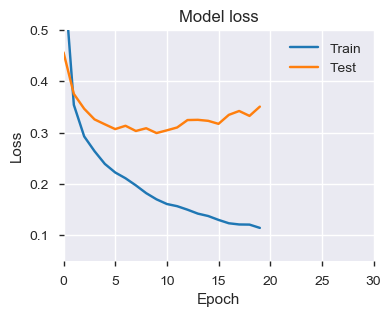

In [568]:
###### Define LSTM model structure & hyperparameters ######
epochs = 30
layers = 2
LSTM_units = 50
dropout = True
dropout_rate = 0.2
kernel_reg = True
kernel_reg_alpha = 5 * 10 ** -5

# Keep track of parameters in filename
model_name = '{}_{}hrs_{}epochs_{}lyrs_{}unts'.format( station[:5], nfuts, epochs, layers, LSTM_units )
if dropout:
    rate = dropout_rate
    model_name += '_{}drp'.format( str(rate).replace('.','p') )
else:
    model_name += '_nodrop'
if kernel_reg:
    alpha = kernel_reg_alpha
    model_name += '_{}kreg'.format( str(alpha).replace('.','p').replace('-','') )
else:
    model_name += '_nokreg'
    
seq_return = [True]*(layers-1) + [False]


###### Build Model ######
model = Sequential()

# Depending on model structure and parameters, add various layers
for i in range(layers):
    
    # Do we need to feed sequences to next layer of the network?
    if i == 1:
        model.add(LSTM(LSTM_units, return_sequences = seq_return[i], input_shape=(nlags, n_features)))
    else:
        model.add(LSTM(LSTM_units, return_sequences = seq_return[i]))
        
    # Do we add a dropout layer?
    # - requires that important features are distributed amongst several nodes
    if dropout:
        model.add(Dropout(rate))

    # Do we regularize?
    # - penalizes large weights and avoids overfitting
    if kernel_reg:
        model.add(Dense(1, kernel_regularizer=regularizers.l2(alpha)))
    else:
        model.add(Dense(1))
        

# use these tools to avoid overfitting
checkpointer = ModelCheckpoint(filepath='./models/' + model_name + '.hdf5',
                               monitor='val_loss',
                               verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=1, min_delta=.001)        
        
# compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=168,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, earlystopping] )

# Plot training & validation loss values
f, ax = plt.subplots(figsize=(4,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim([0, epochs])
ax.set_ylim([0.05, 0.5])
ax.legend(['Train', 'Test'], loc='upper right')
plt.savefig('./model_evaluation/{}.png'.format(model_name))

In [467]:
# evaluate predictions n-days out
# 1) of model
y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred,(len(y_pred), ))
y_pred = SS_test.inverse_transform(y_pred) # recover initial values
y_pred = y_pred[1:]

# 2) of naiive prediction where next day = mean(previous 24hrs)
y_pred_naiive = X_test[:,-nfuts-1,0]
y_pred_naiive = y_pred_naiive[1:]
y_pred_naiive = SS_test.inverse_transform(y_pred_naiive) # recover initial values

# 3) actual values
y_true = tmp_testing_df.loc[:, yvar].values
# y_true = y_true[:-(nfuts+nlags-1) if nfuts>1 else None]

# 4) Fix nfuts offset:
# rolling avg on Xtest is computing the t+1 datapoint
# y_pred and y_true correspond to t+nfuts
y_pred = y_pred[:-nfuts]
y_pred_naiive = y_pred_naiive[nfuts:]
y_true = y_true[:-nfuts]

# 5) not trying to predict zero values (when the company itself just shuts off power from wind farms)
zeros = y_true==0
print(sum(zeros))
y_pred[zeros] =  0
y_pred_naiive[zeros] = 0

# triple check that our predictions all have the same length
print(np.shape(y_pred))
print(np.shape(y_pred_naiive))
print(np.shape(y_true))

# create prediction dataframe for evaluation
time = np.linspace(0,len(y_pred),len(y_pred))
resultsdf = pd.DataFrame({
    'time': time,
    'actual': y_true,
    'predicted': y_pred,
    'naiive_predicted': y_pred_naiive})

def view_results(df, week):
    # Create fig
    f,ax = plt.subplots(figsize=(12,4))
    df_subset = df.iloc[168*week:168*(week+1),:]

    sns.lineplot(x='time', y='actual', data=df_subset, color="#9b59b6") # purple
    ax2 = plt.twinx()
    sns.lineplot(x='time', y='predicted', data=df_subset, color="#3498db", ax=ax2) # blue
#     sns.lineplot(x='time', y='naiive_predicted', data=df_subset, color="#95a5a6", ax=ax2) # grey

    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Percent Max Power Generation', color="#9b59b6")
    ax2.set_ylabel('Predicted Percent Max Power Generation', color="#3498db")
    ax.set_ylim([0, 1.05])
    ax2.set_ylim([0, 1.05])

    r2model_full = r2_score(df.loc[df['actual']!=0, 'actual'], df.loc[df['predicted']!=0, 'predicted'].values)
    r2naiive_full = r2_score(df.loc[df['actual']!=0, 'actual'], df.loc[df['actual']!=0, 'naiive_predicted'].values)
    
    r2model_sub = r2_score(df_subset.loc[df_subset['actual']!=0, 'actual'], df_subset.loc[df_subset['predicted']!=0, 'predicted'].values)
    r2naiive_sub = r2_score(df_subset.loc[df_subset['actual']!=0, 'actual'], df_subset.loc[df_subset['actual']!=0, 'naiive_predicted'].values)

    ax.set_title('Full Dataset:  Model error = ' + str(round(r2model_full, 4)) + ', Naiive error = ' + str(round(r2naiive_full, 4)) + \
                 '\nSubset Dataset:  Model error = ' + str(round(r2model_sub, 4)) + ', Naiive error = ' + str(round(r2naiive_sub, 4)) + '   ')
    plt.show();

# Interactive visualization week-to-week
interact(view_results,\
         df = fixed(resultsdf),\
         week = (0,52,1));

1905
(8587,)
(8587,)
(8587,)


interactive(children=(IntSlider(value=26, description='week', max=52), Output()), _dom_classes=('widget-intera…